In [1]:
pip install recommenders


## Data format:

**MINDsmall_train** is used for training, and **MINDsmall_dev** is used for evaluation. Training data and evaluation data are composed of a news file and a behaviors file.

### news data
This file contains news information including newsid, category, subcatgory, news title, news abstarct, news url and entities in news title, entities in news abstarct.
One simple example: <br>

`N46466	lifestyle	lifestyleroyals	The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By	Shop the notebooks, jackets, and more that the royals can't live without.	https://www.msn.com/en-us/lifestyle/lifestyleroyals/the-brands-queen-elizabeth,-prince-charles,-and-prince-philip-swear-by/ss-AAGH0ET?ocid=chopendata	[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]	[]`
<br>

In general, each line in data file represents information of one piece of news: <br>

`[News ID] [Category] [Subcategory] [News Title] [News Abstrct] [News Url] [Entities in News Title] [Entities in News Abstract] ...`

<br>

We generate a word_dict file to tranform words in news title to word indexes, and a embedding matrix is initted from pretrained glove embeddings.

### behaviors data
One simple example: <br>
`1	U82271	11/11/2019 3:28:58 PM	N3130 N11621 N12917 N4574 N12140 N9748	N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25810-0 N20820-0 N6885-0 N27294-0 N18835-0 N16945-0 N7410-0 N23967-0 N22679-0 N20532-0 N26651-0 N22078-0 N4098-0 N16473-0 N13841-0 N15660-0 N25787-0 N2315-0 N1615-0 N9087-0 N23880-0 N3600-0 N24479-0 N22882-0 N26308-0 N13594-0 N2220-0 N28356-0 N17083-0 N21415-0 N18671-0 N9440-0 N17759-0 N10861-0 N21830-0 N8064-0 N5675-0 N15037-0 N26154-0 N15368-1 N481-0 N3256-0 N20663-0 N23940-0 N7654-0 N10729-0 N7090-0 N23596-0 N15901-0 N16348-0 N13645-0 N8124-0 N20094-0 N27774-0 N23011-0 N14832-0 N15971-0 N27729-0 N2167-0 N11186-0 N18390-0 N21328-0 N10992-0 N20122-0 N1958-0 N2004-0 N26156-0 N17632-0 N26146-0 N17322-0 N18403-0 N17397-0 N18215-0 N14475-0 N9781-0 N17958-0 N3370-0 N1127-0 N15525-0 N12657-0 N10537-0 N18224-0`
<br>

In general, each line in data file represents one instance of an impression. The format is like: <br>

`[Impression ID] [User ID] [Impression Time] [User Click History] [Impression News]`

<br>

User Click History is the user historical clicked news before Impression Time. Impression News is the displayed news in an impression, which format is:<br>

`[News ID 1]-[label1] ... [News ID n]-[labeln]`

<br>
Label represents whether the news is clicked by the user. All information of news in User Click History and Impression News can be found in news data file.

In [ ]:
import os
import sys
import numpy as np
import zipfile
from tqdm import tqdm
from tempfile import TemporaryDirectory
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.deeprec.deeprec_utils import download_deeprec_resources
from recommenders.models.newsrec.newsrec_utils import prepare_hparams
from recommenders.models.newsrec.models.npa import NPAModel
from recommenders.models.newsrec.io.mind_iterator import MINDIterator
from recommenders.models.newsrec.newsrec_utils import get_mind_data_set
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

#Data Readin

In [45]:
epochs = 5
seed = 42
batch_size = 32
MIND_type = 'small'

In [46]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name
train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'npa.yaml')
mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)
if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)

100%|██████████| 51.7k/51.7k [00:31<00:00, 1.63kKB/s]
100%|██████████| 30.2k/30.2k [00:06<00:00, 4.68kKB/s]
100%|██████████| 152k/152k [00:06<00:00, 21.8kKB/s]


In [47]:
import pandas as pd

# Check if the files exist
print("Training news file exists:", os.path.exists(train_news_file))
print("Training behaviors file exists:", os.path.exists(train_behaviors_file))
print("Validation news file exists:", os.path.exists(valid_news_file))
print("Validation behaviors file exists:", os.path.exists(valid_behaviors_file))

Training news file exists: True
Training behaviors file exists: True
Validation news file exists: True
Validation behaviors file exists: True


# Exploratory data analysis (EDA)

In [48]:
import pandas as pd
#convert to pandas for easy analysis
news_columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
behaviors_columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']
train_news = pd.read_csv(train_news_file, sep='\t', names=news_columns)
train_behaviors = pd.read_csv(train_behaviors_file, sep='\t', names=behaviors_columns)
valid_news = pd.read_csv(valid_news_file, sep='\t', names=news_columns)
valid_behaviors = pd.read_csv(valid_behaviors_file, sep='\t', names=behaviors_columns)
print("\nSample from training news file:")
train_news.head()



Sample from training news file:


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [49]:
print("\nSample from training behaviors file:")
train_behaviors.head()


Sample from training behaviors file:


,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [50]:
print("\nSample from validation news file:")
valid_news.head()


Sample from validation news file:


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [51]:
print("\nSample from validation behaviors file:")
valid_behaviors.head()


Sample from validation behaviors file:


,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


In [52]:
# Display basic statistics
print("\nTraining news data statistics:")
train_news.describe(include='all')


Training news data statistics:


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
count,51282,51282,51282,51282,48616,51282,51279,51278
unique,51282,17,264,50434,47309,51281,34472,36277
top,N55528,news,newsus,Photos of the Day,What's the weather today? What's the weather f...,[],[],[]
freq,1,15774,6564,15,124,2,13842,13825


In [53]:
print("\nTraining behaviors data statistics:")
train_behaviors.describe(include='all')


Training behaviors data statistics:


,impression_id,user_id,time,history,impressions
count,156965.000000,156965,156965,153727,156965
unique,NaN,50000,125501,48868,143617
top,NaN,U32146,11/13/2019 11:11:34 AM,N17933 N55829 N61864 N46346 N29597 N52097 N291...,N35729-0 N55689-1
freq,NaN,62,6,62,452
mean,78483.000000,NaN,NaN,NaN,NaN
std,45312.036839,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN
25%,39242.000000,NaN,NaN,NaN,NaN
50%,78483.000000,NaN,NaN,NaN,NaN
75%,117724.000000,NaN,NaN,NaN,NaN


In [54]:
print("\nValidation news data statistics:")
valid_news.describe(include='all')



Validation news data statistics:


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
count,42416,42416,42416,42416,40395,42416,42414,42414
unique,42416,17,257,41823,39470,42416,28800,29889
top,N55528,news,newsus,Look of the Day,What's the weather today? What's the weather f...,https://assets.msn.com/labs/mind/AAGH0ET.html,[],[]
freq,1,13043,5335,16,68,1,11286,11620


In [55]:

print("\nValidation behaviors data statistics:")
valid_behaviors.describe(include='all')


Validation behaviors data statistics:


,impression_id,user_id,time,history,impressions
count,73152.000000,73152,73152,70938,73152
unique,NaN,50000,40320,48353,67949
top,NaN,U38741,11/15/2019 8:06:57 AM,N58794 N37211 N48304 N41854 N16317 N20297 N225...,N36779-0 N20036-1
freq,NaN,18,10,18,692
mean,36576.500000,NaN,NaN,NaN,NaN
std,21117.307783,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN
25%,18288.750000,NaN,NaN,NaN,NaN
50%,36576.500000,NaN,NaN,NaN,NaN
75%,54864.250000,NaN,NaN,NaN,NaN


In [56]:
# Check for missing values
print("\nMissing values in training news data:")
print(train_news.isnull().sum())


Missing values in training news data:
news_id                 0
category                0
subcategory             0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64


In [57]:
print("\nMissing values in training behaviors data:")
train_behaviors.isnull().sum()


Missing values in training behaviors data:


impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

In [58]:
print("\nMissing values in validation news data:")
valid_news.isnull().sum()


Missing values in validation news data:


news_id                 0
category                0
subcategory             0
title                   0
abstract             2021
url                     0
title_entities          2
abstract_entities       2
dtype: int64

In [59]:
print("\nMissing values in validation behaviors data:")
valid_behaviors.isnull().sum()


Missing values in validation behaviors data:


impression_id       0
user_id             0
time                0
history          2214
impressions         0
dtype: int64

<ipython-input-60-10c120528253>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_news, x='category', order=train_news['category'].value_counts().index, palette='tab20')


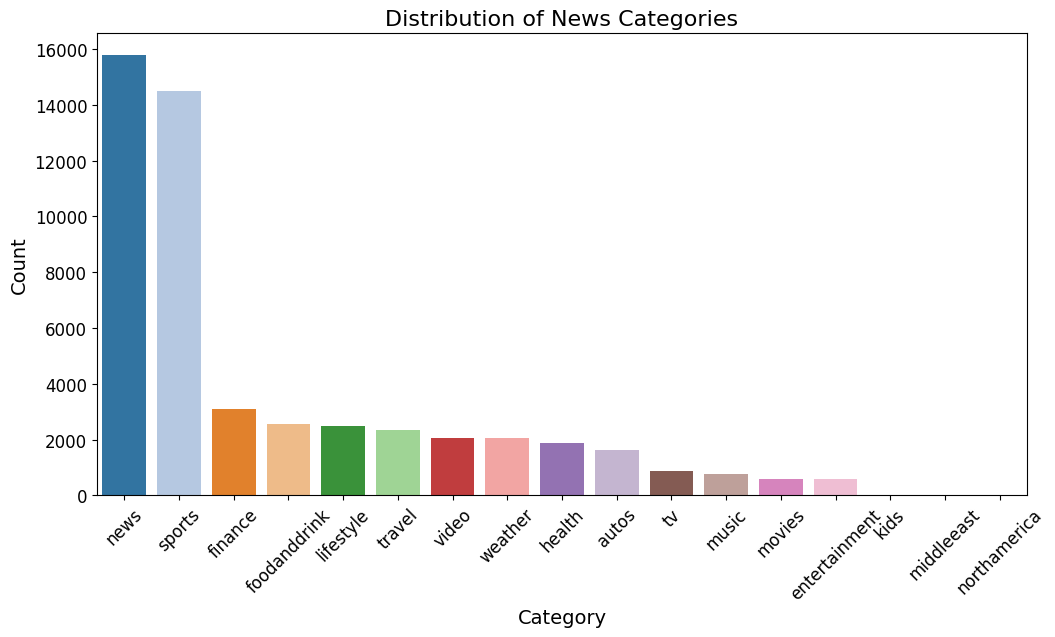

<ipython-input-60-10c120528253>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_train_news, x='subcategory', order=top_10_subcategories, palette='Blues_d')


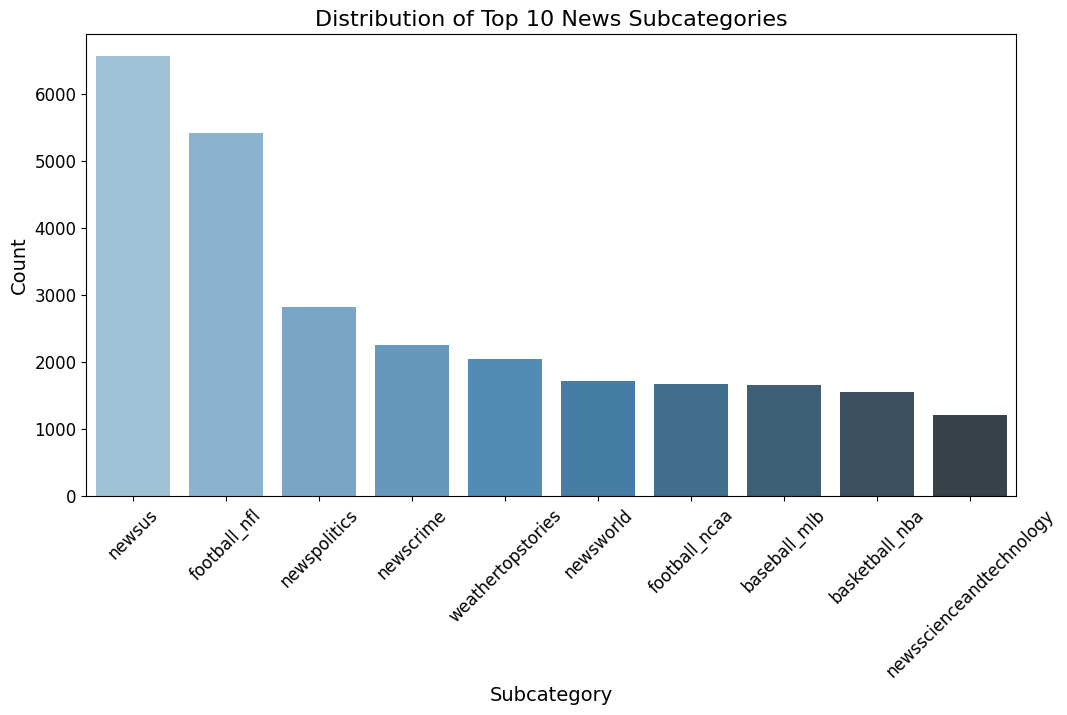

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define font sizes
title_font_size = 16
axis_label_font_size = 14
tick_label_font_size = 12

# Distribution of News Categories
plt.figure(figsize=(12, 6))
sns.countplot(data=train_news, x='category', order=train_news['category'].value_counts().index, palette='tab20')
plt.title('Distribution of News Categories', fontsize=title_font_size)
plt.xlabel('Category', fontsize=axis_label_font_size)
plt.ylabel('Count', fontsize=axis_label_font_size)
plt.xticks(rotation=45, fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.show()

# Distribution of Top 10 News Subcategories
top_10_subcategories = train_news['subcategory'].value_counts().nlargest(10).index
filtered_train_news = train_news[train_news['subcategory'].isin(top_10_subcategories)]

plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_train_news, x='subcategory', order=top_10_subcategories, palette='Blues_d')
plt.title('Distribution of Top 10 News Subcategories', fontsize=title_font_size)
plt.xlabel('Subcategory', fontsize=axis_label_font_size)
plt.ylabel('Count', fontsize=axis_label_font_size)
plt.xticks(rotation=45, fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)
plt.show()


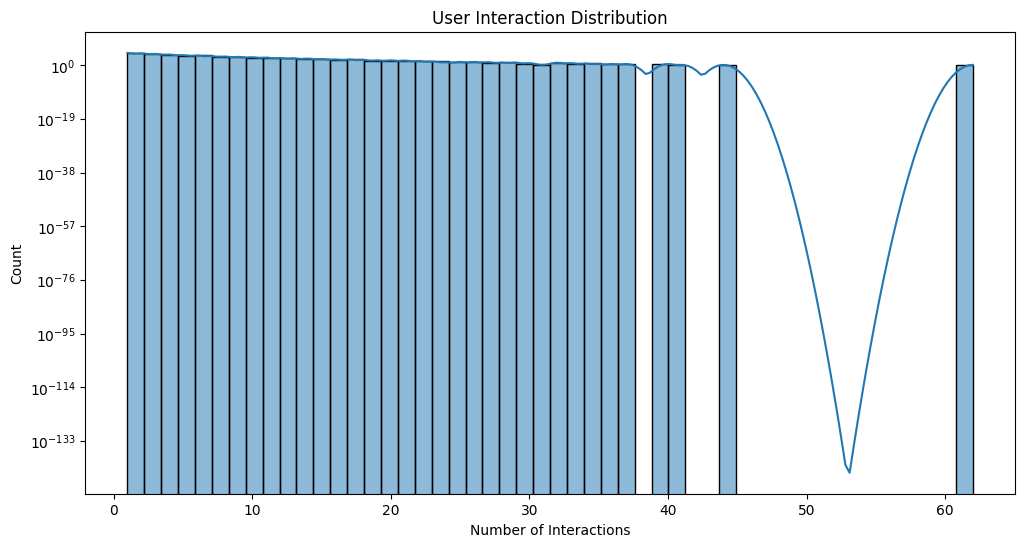

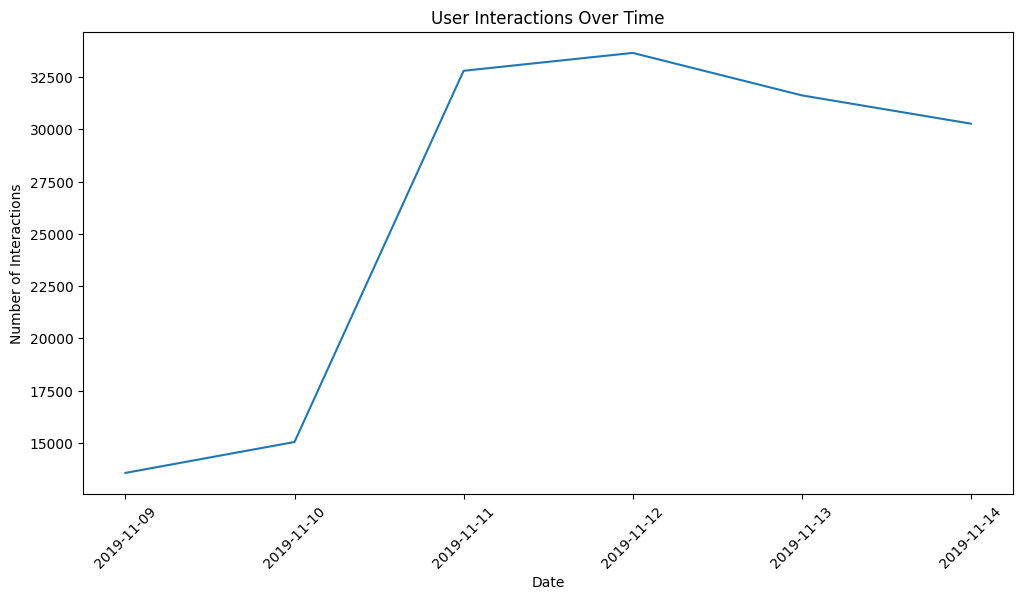

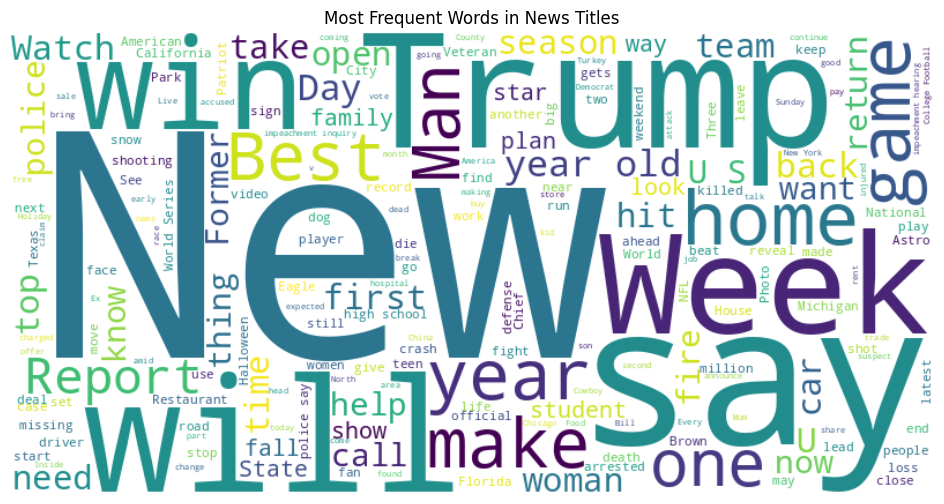

In [61]:

#  User Interaction Analysis
user_interactions = train_behaviors['user_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_interactions, bins=50, kde=True)
plt.title('User Interaction Distribution')
plt.xlabel('Number of Interactions')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

# Temporal Analysis of User Interactions
train_behaviors['time'] = pd.to_datetime(train_behaviors['time'])
train_behaviors['date'] = train_behaviors['time'].dt.date
interaction_dates = train_behaviors['date'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
interaction_dates.plot()
plt.title('User Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()

# Most Frequent Words in News Titles
all_titles = ' '.join(train_news['title'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in News Titles')
plt.show()




#Sentiment Analysis Using Distilled Bert

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!pip install transformers tqdm

In [64]:
train_with_sentiment ='/content/drive/MyDrive/machine_learning/train_news_with_mood.csv'
train_with_sentiment_df = pd.read_csv(train_with_sentiment)

In [65]:
train_with_sentiment_df.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,mood
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],sadness
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",joy
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",fear
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",sadness
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",joy


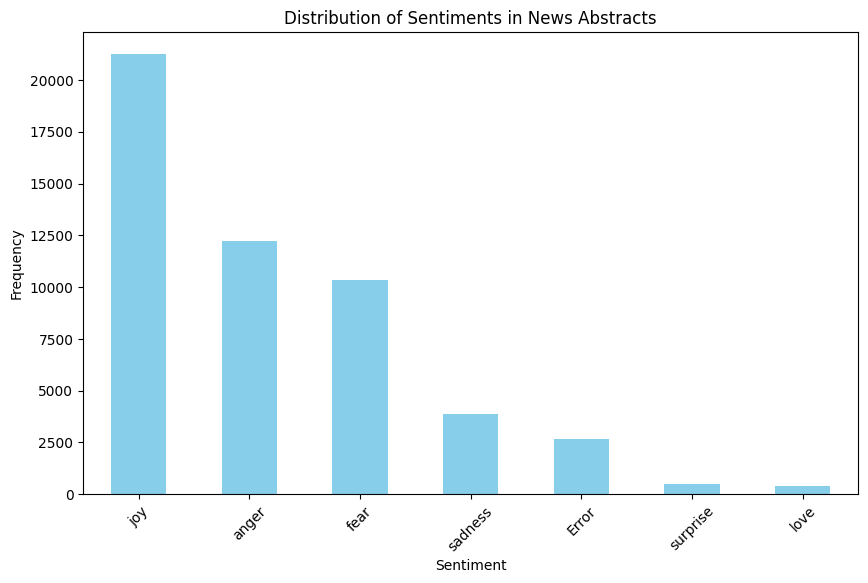

In [66]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the frequency of each sentiment
sentiment_counts = train_with_sentiment_df['mood'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiments in News Abstracts')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [67]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

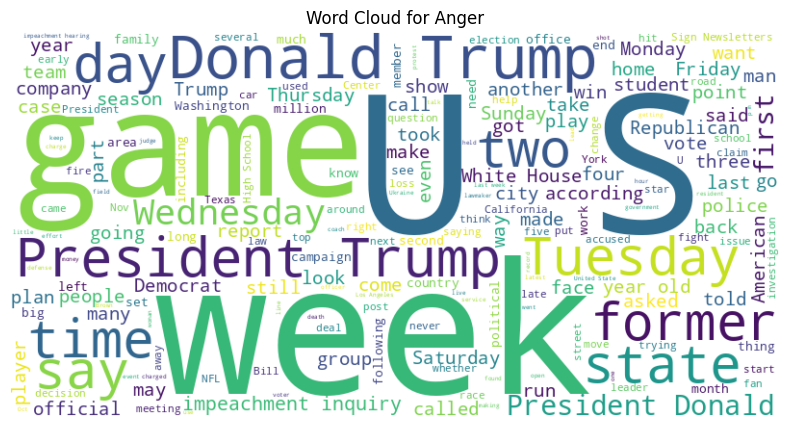

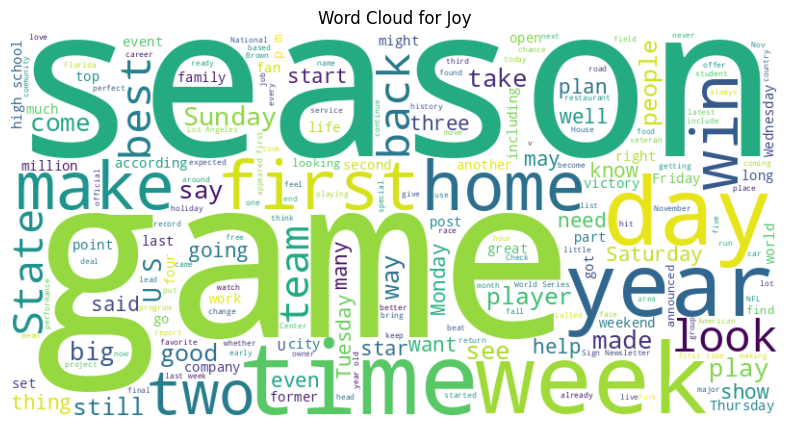

In [69]:
# Filter the data for 'anger' and 'joy' moods
anger_texts = train_with_sentiment_df[train_with_sentiment_df['mood'] == 'anger']['abstract']
joy_texts = train_with_sentiment_df[train_with_sentiment_df['mood'] == 'joy']['abstract']
custom_stop_words = set(stopwords.words('english')) | {'will', 'news','new','said','one','year','team','say'}
def generate_word_cloud(texts, title):
    # Combine all texts
    combined_text = " ".join(text for text in texts)
    # Remove stop words
    filtered_text = ' '.join(word for word in combined_text.split() if word.lower() not in custom_stop_words)
    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Generate word cloud for anger
generate_word_cloud(anger_texts, "Word Cloud for Anger")

# Generate word cloud for joy
generate_word_cloud(joy_texts, "Word Cloud for Joy")

In [70]:
# import re

# def clean_text(text):
#     """
#     Function to clean text data by removing URLs, non-alphanumeric characters,
#     and converting to lowercase.
#     """
#     text = re.sub(r'https?://\S+', '', text)  # Remove URLs
#     text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
#     text = text.lower()  # Convert to lowercase
#     return text


In [71]:
# def detect_mood(text):
#     try:
#         # Clean the text
#         cleaned_text = clean_text(text)
#         # Perform sentiment analysis
#         results = classifier(cleaned_text)
#         # Extract the label with the highest score
#         mood = results[0]['label']
#         return mood
#     except Exception as e:
#         return 'Error'
